# FP-Growth

In [18]:
def transfer2FrozenDataSet(dataSet):
    frozenDataSet = {}
    for elem in dataSet:
        frozenDataSet[frozenset(elem)] = 1
    return frozenDataSet

class TreeNode:
    def __init__(self, nodeName, count, nodeParent):
        self.nodeName = nodeName
        self.count = count
        self.nodeParent = nodeParent
        self.nextSimilarItem = None
        self.children = {}

    def increaseC(self, count):
        self.count += count

def createFPTree(frozenDataSet, minSupport):
    #scan dataset at the first time, filter out items which are less than minSupport
    headPointTable = {}
    for items in frozenDataSet:
        for item in items:
            headPointTable[item] = headPointTable.get(item, 0) + frozenDataSet[items]
    headPointTable = {k:v for k,v in headPointTable.items() if v >= minSupport}
    frequentItems = set(headPointTable.keys())
    if len(frequentItems) == 0: return None, None

    for k in headPointTable:
        headPointTable[k] = [headPointTable[k], None]
    fptree = TreeNode("null", 1, None)
    #scan dataset at the second time, filter out items for each record
    for items,count in frozenDataSet.items():
        frequentItemsInRecord = {}
        for item in items:
            if item in frequentItems:
                frequentItemsInRecord[item] = headPointTable[item][0]
        if len(frequentItemsInRecord) > 0:
            orderedFrequentItems = [v[0] for v in sorted(frequentItemsInRecord.items(), key=lambda v:v[1], reverse = True)]
            updateFPTree(fptree, orderedFrequentItems, headPointTable, count)

    return fptree, headPointTable

def updateFPTree(fptree, orderedFrequentItems, headPointTable, count):
    #handle the first item
    if orderedFrequentItems[0] in fptree.children:
        fptree.children[orderedFrequentItems[0]].increaseC(count)
    else:
        fptree.children[orderedFrequentItems[0]] = TreeNode(orderedFrequentItems[0], count, fptree)

        #update headPointTable
        if headPointTable[orderedFrequentItems[0]][1] == None:
            headPointTable[orderedFrequentItems[0]][1] = fptree.children[orderedFrequentItems[0]]
        else:
            updateHeadPointTable(headPointTable[orderedFrequentItems[0]][1], fptree.children[orderedFrequentItems[0]])
    #handle other items except the first item
    if(len(orderedFrequentItems) > 1):
        updateFPTree(fptree.children[orderedFrequentItems[0]], orderedFrequentItems[1::], headPointTable, count)

def updateHeadPointTable(headPointBeginNode, targetNode):
    while(headPointBeginNode.nextSimilarItem != None):
        headPointBeginNode = headPointBeginNode.nextSimilarItem
    headPointBeginNode.nextSimilarItem = targetNode

def mineFPTree(headPointTable, prefix, frequentPatterns, minSupport):
    #for each item in headPointTable, find conditional prefix path, create conditional fptree, then iterate until there is only one element in conditional fptree
    headPointItems = [v[0] for v in sorted(headPointTable.items(), key = lambda v:v[1][0])]
    if(len(headPointItems) == 0): return

    for headPointItem in headPointItems:
        newPrefix = prefix.copy()
        newPrefix.add(headPointItem)
        support = headPointTable[headPointItem][0]
        frequentPatterns[frozenset(newPrefix)] = support

        prefixPath = getPrefixPath(headPointTable, headPointItem)
        if(prefixPath != {}):
            conditionalFPtree, conditionalHeadPointTable = createFPTree(prefixPath, minSupport)
            if conditionalHeadPointTable != None:
                mineFPTree(conditionalHeadPointTable, newPrefix, frequentPatterns, minSupport)

def getPrefixPath(headPointTable, headPointItem):
    prefixPath = {}
    beginNode = headPointTable[headPointItem][1]
    prefixs = ascendTree(beginNode)
    if((prefixs != [])):
        prefixPath[frozenset(prefixs)] = beginNode.count

    while(beginNode.nextSimilarItem != None):
        beginNode = beginNode.nextSimilarItem
        prefixs = ascendTree(beginNode)
        if (prefixs != []):
            prefixPath[frozenset(prefixs)] = beginNode.count
    return prefixPath

def ascendTree(treeNode):
    prefixs = []
    while((treeNode.nodeParent != None) and (treeNode.nodeParent.nodeName != 'null')):
        treeNode = treeNode.nodeParent
        prefixs.append(treeNode.nodeName)
    return prefixs

def rulesGenerator(frequentPatterns, minConf, rules):
    for frequentset in frequentPatterns:
        if(len(frequentset) > 1):
            getRules(frequentset,frequentset, rules, frequentPatterns, minConf)

def removeStr(set, str):
    tempSet = []
    for elem in set:
        if(elem != str):
            tempSet.append(elem)
    tempFrozenSet = frozenset(tempSet)
    return tempFrozenSet


def getRules(frequentset,currentset, rules, frequentPatterns, minConf):
    for frequentElem in currentset:
        subSet = removeStr(currentset, frequentElem)
        confidence = frequentPatterns[frequentset] / frequentPatterns[subSet]
        if (confidence >= minConf):
            flag = False
            for rule in rules:
                if(rule[0] == subSet and rule[1] == frequentset - subSet):
                    flag = True
            if(flag == False):
                rules.append((subSet, frequentset - subSet, confidence))

            if(len(subSet) >= 2):
                getRules(frequentset, subSet, rules, frequentPatterns, minConf)

def fpGrowth(dataSet, minSupport):
#     dataSet = pluno_merge
    frozenDataSet = transfer2FrozenDataSet(dataSet)
#     minSupport = 32
    fptree, headPointTable = createFPTree(frozenDataSet, minSupport)
    # fptree.disp()
    frequentPatterns = {}
    prefix = set([])
    mineFPTree(headPointTable, prefix, frequentPatterns, minSupport)
    print("frequent patterns:")
    for item in frequentPatterns:
        print(item, frequentPatterns[item])
    minConf = 0.6
    rules = []
#     rulesGenerator(frequentPatterns, minConf, rules)
#     print("association rules:")
#     for item in rules:
#         print(item)

# Load Data

### trade_new.csv

In [59]:
import numpy as np
import pandas as pd
with open('./trade_new.csv', 'r') as resourse_data:
    data = pd.read_csv(resourse_data)[['vipno', 'sldatime', 'pluno', 'dptno', 'bndno']]
data['sldatime'] = pd.to_datetime(data['sldatime'])



#### i. 分别以pluno、dptno和bndno为频繁集挖掘的item_no，通过FP-Growth算法挖掘pluno、dptno和bndno的频繁集，其中要求support为2，4，8，16，32，64等共计6个阈值


In [60]:
sorted_vipno = data.sort_values(['sldatime'],ascending=True).groupby(['vipno', 'sldatime'])
pluno_slice = []
dptno_slice = []
bndno_slice = []
for x in sorted_vipno:
    length = int(len(x[1])*0.6)
    if length < 1:
        length = 1
    plu_temp = list(x[1]['pluno'].head(length))
    pluno_slice.append(plu_temp)
    dpt_temp = list(x[1]['dptno'].head(length))
    dptno_slice.append(dpt_temp)
    bnd_temp = list(x[1]['bndno'].head(length).dropna().astype(int))
    bndno_slice.append(bnd_temp)
# print(pluno_slice)


In [61]:
while [] in bndno_slice:
    bndno_slice.remove([])

In [6]:
import time
pluno_runtime = []
dptno_runtime = []
bndno_runtime = []
support = [2, 4, 8, 16, 32, 64]

In [ ]:
import matplotlib.pyplot as plt

In [35]:
def get_runtime(support, data):
    temp = []
    for i in support:
        start = time.clock()
        fpGrowth(data, i)
        end = time.clock()
        temp.append(end - start)
    return temp
    
def time_table(support, pluno_runtime, dptno_runtime, bndno_runtime, y):
    n_groups = len(support)

    fig, ax = plt.subplots()    
    index = np.arange(n_groups)    
    bar_width = 0.3  
         
    opacity = 0.4    
    rects1 = plt.bar(index, pluno_runtime, bar_width,alpha=opacity, color='k',label='pluno')    
    rects2 = plt.bar(index + bar_width, dptno_runtime, bar_width,alpha=opacity,color='b',label='dptno')    
    rects2 = plt.bar(index + bar_width * 2, bndno_runtime, bar_width,alpha=opacity,color='c',label='bndno')    

    plt.xlabel('Support')    
    plt.ylabel('Time')    
    plt.title('Time by support and itemno')    
    plt.xticks(index + bar_width, support)    
    plt.ylim(0, y);    
    plt.legend();    
      
    plt.tight_layout();   
    plt.show();

In [33]:
pluno_runtime = get_runtime(support, pluno_slice)
dptno_runtime = get_runtime(support, dptno_slice)
bndno_runtime = get_runtime(support, bndno_slice)

frequent patterns:
frozenset({10119019}) 2
frozenset({14903003}) 2
frozenset({14091009}) 2
frozenset({14092015}) 2
frozenset({22630010}) 2
frozenset({10130001}) 2
frozenset({14905007}) 2
frozenset({15139018}) 2
frozenset({15004053}) 2
frozenset({14121013}) 2
frozenset({14900021}) 2
frozenset({14831034}) 2
frozenset({14407009}) 2
frozenset({11501060}) 2
frozenset({14570011}) 2
frozenset({15110003}) 2
frozenset({14811004}) 2
frozenset({14815007}) 2
frozenset({14860020}) 2
frozenset({14830021}) 2
frozenset({11303134}) 2
frozenset({27410007}) 2
frozenset({15219007}) 2
frozenset({14092063}) 2
frozenset({11521012}) 2
frozenset({22500001}) 2
frozenset({32143002}) 2
frozenset({24220016}) 2
frozenset({10002022}) 2
frozenset({14833011}) 2
frozenset({30380002, 14833011}) 2
frozenset({22001000}) 2
frozenset({15242009}) 2
frozenset({10119139}) 2
frozenset({10150003}) 2
frozenset({14231008}) 2
frozenset({15212006}) 2
frozenset({15115046}) 2
frozenset({11502024}) 2
frozenset({11502024, 30380002}) 2
f

frozenset({14072004}) 4
frozenset({27300281}) 4
frozenset({15112000}) 4
frozenset({22007005}) 4
frozenset({25121022}) 4
frozenset({14091073}) 4
frozenset({20121037}) 4
frozenset({15115001}) 4
frozenset({15110028}) 4
frozenset({22701014}) 4
frozenset({20121056}) 4
frozenset({27002584}) 4
frozenset({22034026}) 4
frozenset({27210006}) 4
frozenset({27002436}) 4
frozenset({21801072}) 4
frozenset({15242002}) 4
frozenset({27200170}) 4
frozenset({10141040}) 4
frozenset({34133016}) 4
frozenset({15230004}) 4
frozenset({10152013}) 4
frozenset({10000015}) 4
frozenset({22172003}) 4
frozenset({22630009}) 4
frozenset({22830002}) 4
frozenset({15430000}) 4
frozenset({22111012}) 4
frozenset({25111051}) 4
frozenset({10137009}) 4
frozenset({14000002}) 4
frozenset({14082022}) 4
frozenset({25112008}) 4
frozenset({22003002}) 4
frozenset({15202002}) 4
frozenset({24010000}) 4
frozenset({15232001}) 4
frozenset({15110004}) 4
frozenset({20121061}) 4
frozenset({15110014}) 4
frozenset({14091046}) 4
frozenset({24000

frozenset({22008, 24010, 10439}) 2
frozenset({22132}) 2
frozenset({24010, 22132}) 2
frozenset({21200}) 2
frozenset({21200, 24010}) 2
frozenset({21200, 22111}) 2
frozenset({21200, 24010, 22111}) 2
frozenset({14525}) 2
frozenset({14563}) 2
frozenset({14043}) 2
frozenset({36010}) 2
frozenset({30800}) 2
frozenset({22860}) 2
frozenset({22040}) 2
frozenset({31017}) 2
frozenset({14902}) 2
frozenset({31002}) 2
frozenset({14741}) 2
frozenset({34424}) 2
frozenset({14840}) 2
frozenset({14401}) 2
frozenset({15234}) 2
frozenset({30514}) 2
frozenset({11046}) 2
frozenset({15200, 11046}) 2
frozenset({30000}) 2
frozenset({15012}) 2
frozenset({14051}) 2
frozenset({31022}) 2
frozenset({32030}) 2
frozenset({10008}) 2
frozenset({30420}) 2
frozenset({14835}) 3
frozenset({14407}) 3
frozenset({14770}) 3
frozenset({14770, 30380}) 2
frozenset({14570}) 3
frozenset({23130}) 3
frozenset({23130, 23110}) 2
frozenset({14105}) 3
frozenset({11022}) 3
frozenset({14815}) 3
frozenset({22111, 14815}) 2
frozenset({11233}) 3

frozenset({27002, 27100}) 2
frozenset({27100, 22111}) 2
frozenset({15202, 27100}) 2
frozenset({27410, 27100}) 2
frozenset({30380, 27100}) 3
frozenset({27100, 23110}) 3
frozenset({15200, 27100}) 3
frozenset({27000, 27100}) 5
frozenset({24010}) 26
frozenset({24010, 15115}) 2
frozenset({22008, 24010}) 2
frozenset({24010, 24101}) 2
frozenset({24010, 27300}) 2
frozenset({24010, 22102}) 3
frozenset({24010, 22102, 22111}) 2
frozenset({24010, 27410}) 3
frozenset({24010, 27410, 23110}) 2
frozenset({24010, 30380}) 3
frozenset({25120, 24010}) 3
frozenset({25120, 24010, 23110}) 2
frozenset({24010, 23110}) 4
frozenset({24010, 15110}) 5
frozenset({24010, 22111}) 5
frozenset({22100}) 26
frozenset({24010, 22100}) 2
frozenset({24010, 22100, 22111}) 2
frozenset({15115, 22100}) 2
frozenset({27300, 15115, 22100}) 2
frozenset({30380, 15115, 22100}) 2
frozenset({30380, 15115, 22100, 27300}) 2
frozenset({15115, 22100, 24101}) 2
frozenset({27300, 15115, 22100, 24101}) 2
frozenset({30380, 15115, 22100, 24101})

frozenset({27300, 25111}) 5
frozenset({25101, 25111}) 6
frozenset({30380, 25111}) 7
frozenset({27410, 25111}) 9
frozenset({27000, 25111}) 12
frozenset({15200}) 42
frozenset({15200, 23110}) 4
frozenset({15200, 15110}) 5
frozenset({15200, 30380}) 5
frozenset({23132}) 44
frozenset({23132, 25101}) 4
frozenset({27002, 23132}) 4
frozenset({23132, 22111}) 4
frozenset({27300, 23132}) 5
frozenset({23132, 23110}) 6
frozenset({23132, 22103}) 7
frozenset({10141}) 44
frozenset({27000, 10141}) 5
frozenset({10141, 23110}) 5
frozenset({30380, 10141}) 17
frozenset({27200}) 46
frozenset({27200, 23110}) 4
frozenset({27200, 25120}) 5
frozenset({27200, 27410}) 11
frozenset({27200, 27000}) 12
frozenset({25120}) 50
frozenset({25120, 27300}) 4
frozenset({25120, 22103}) 4
frozenset({25120, 30380}) 5
frozenset({25120, 25101}) 7
frozenset({25120, 23110}) 7
frozenset({25120, 27000, 23110}) 4
frozenset({25120, 27410}) 8
frozenset({25120, 27000}) 12
frozenset({22111}) 50
frozenset({23110, 22111}) 5
frozenset({27002

frozenset({10706, 10086}) 4
frozenset({14810}) 14
frozenset({14810, 15052}) 2
frozenset({30248, 14810}) 3
frozenset({15038}) 15
frozenset({14322, 15038}) 2
frozenset({10086, 15038}) 2
frozenset({15052, 15038}) 2
frozenset({15038, 15631}) 2
frozenset({30248, 15038}) 2
frozenset({14098}) 15
frozenset({30248, 14098}) 2
frozenset({30170}) 15
frozenset({30170, 15012}) 2
frozenset({30248, 30170}) 4
frozenset({14362}) 15
frozenset({14362, 15092}) 2
frozenset({30248, 14362, 15092}) 2
frozenset({14362, 10086}) 2
frozenset({14362, 15012}) 3
frozenset({14362, 15631}) 3
frozenset({30248, 14362}) 4
frozenset({14281}) 16
frozenset({14281, 15094}) 2
frozenset({14281, 10086}) 2
frozenset({14281, 14196}) 5
frozenset({30248, 14281, 14196}) 3
frozenset({30248, 14281}) 6
frozenset({14322}) 18
frozenset({14322, 10086}) 2
frozenset({30248, 14322}) 2
frozenset({14322, 15094}) 3
frozenset({14196}) 19
frozenset({14196, 15039}) 2
frozenset({30248, 14196}) 6
frozenset({10060}) 23
frozenset({10060, 15039}) 2
froz

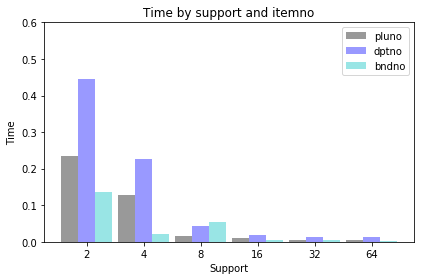

In [36]:
time_table(support, pluno_runtime, dptno_runtime, bndno_runtime, 0.6)

### trade.csv

In [13]:
with open('./trade.csv', 'r') as resourse_data2:
    data2 = pd.read_csv(resourse_data2)[['vipno', 'sldat', 'pluno', 'dptno', 'bndno']]
data2['sldat'] = pd.to_datetime(data2['sldat'])

In [62]:
sorted_vipno2 = data2.sort_values(['sldat'],ascending=True).groupby(['vipno', 'sldat'])
pluno_slice2 = []
dptno_slice2 = []
bndno_slice2 = []
for x in sorted_vipno2:
    length = int(len(x[1])*0.6)
    if length < 1:
        length = 1
    plu_temp = list(x[1]['pluno'].head(length))
    pluno_slice2.append(plu_temp)
    dpt_temp = list(x[1]['dptno'].head(length))
    dptno_slice2.append(dpt_temp)
    bnd_temp = list(x[1]['bndno'].head(length).dropna().astype(int))
    bndno_slice2.append(bnd_temp)

In [15]:
while [] in bndno_slice2:
    bndno_slice2.remove([])

In [24]:
import time
pluno_runtime2 = []
dptno_runtime2 = []
bndno_runtime2 = []

In [37]:
pluno_runtime2 = get_runtime(support, pluno_slice2)
dptno_runtime2 = get_runtime(support, dptno_slice2)
bndno_runtime2 = get_runtime(support, bndno_slice2)

frequent patterns:
frozenset({10119019}) 2
frozenset({14903003}) 2
frozenset({14091009}) 2
frozenset({14092015}) 2
frozenset({22630010}) 2
frozenset({10130001}) 2
frozenset({14905007}) 2
frozenset({15139018}) 2
frozenset({15004053}) 2
frozenset({14121013}) 2
frozenset({14900021}) 2
frozenset({14831034}) 2
frozenset({14407009}) 2
frozenset({11501060}) 2
frozenset({14570011}) 2
frozenset({15110003}) 2
frozenset({14811004}) 2
frozenset({14815007}) 2
frozenset({14860020}) 2
frozenset({14830021}) 2
frozenset({11303134}) 2
frozenset({27410007}) 2
frozenset({15219007}) 2
frozenset({14092063}) 2
frozenset({11521012}) 2
frozenset({22500001}) 2
frozenset({32143002}) 2
frozenset({24220016}) 2
frozenset({10002022}) 2
frozenset({14833011}) 2
frozenset({30380002, 14833011}) 2
frozenset({22001000}) 2
frozenset({15242009}) 2
frozenset({10119139}) 2
frozenset({10150003}) 2
frozenset({14231008}) 2
frozenset({15212006}) 2
frozenset({15115046}) 2
frozenset({11502024}) 2
frozenset({11502024, 30380002}) 2
f

frozenset({11501065}) 5
frozenset({15402007}) 5
frozenset({15114033}) 5
frozenset({27002167}) 5
frozenset({15110002}) 5
frozenset({23110174}) 5
frozenset({15116003}) 5
frozenset({10132003}) 5
frozenset({14091047}) 5
frozenset({10000025}) 5
frozenset({22020002}) 5
frozenset({22130000}) 5
frozenset({15110031}) 5
frozenset({22103004}) 5
frozenset({15200008}) 5
frozenset({10000006}) 5
frozenset({10140002}) 5
frozenset({23112013}) 5
frozenset({14013010}) 5
frozenset({10132017}) 5
frozenset({14092021}) 5
frozenset({15114013}) 5
frozenset({14515001}) 5
frozenset({21021043}) 5
frozenset({22671077}) 5
frozenset({15433002}) 5
frozenset({27400126}) 5
frozenset({10000011}) 5
frozenset({22130007}) 5
frozenset({27002176}) 5
frozenset({22103003}) 5
frozenset({27000007}) 5
frozenset({25012012}) 5
frozenset({22111001}) 5
frozenset({25101002}) 5
frozenset({22102004}) 5
frozenset({27300276}) 5
frozenset({14513033}) 5
frozenset({14513033, 14258011}) 5
frozenset({15200001}) 5
frozenset({15110069}) 5
frozen

frozenset({27000, 25120, 14021}) 2
frozenset({15149}) 2
frozenset({30503}) 2
frozenset({30320}) 2
frozenset({14215}) 2
frozenset({23110, 14215}) 2
frozenset({30364}) 2
frozenset({22850}) 2
frozenset({22850, 22102}) 2
frozenset({30131}) 2
frozenset({14644}) 2
frozenset({14644, 14661}) 2
frozenset({14644, 14636}) 2
frozenset({14644, 14661, 14636}) 2
frozenset({14644, 14830}) 2
frozenset({14644, 14636, 14830}) 2
frozenset({14644, 14661, 14830}) 2
frozenset({14636, 14644, 14661, 14830}) 2
frozenset({14654}) 2
frozenset({14661, 14654}) 2
frozenset({14636, 14654}) 2
frozenset({14636, 14661, 14654}) 2
frozenset({14830, 14654}) 2
frozenset({14636, 14830, 14654}) 2
frozenset({14661, 14830, 14654}) 2
frozenset({14636, 14661, 14830, 14654}) 2
frozenset({14644, 14654}) 2
frozenset({14644, 14636, 14654}) 2
frozenset({14644, 14661, 14654}) 2
frozenset({14636, 14644, 14661, 14654}) 2
frozenset({14644, 14830, 14654}) 2
frozenset({14636, 14644, 14830, 14654}) 2
frozenset({14661, 14644, 14830, 14654}) 2

frozenset({15000, 23110}) 3
frozenset({15000, 30380, 23110}) 2
frozenset({15000, 15110}) 3
frozenset({15000, 27300}) 3
frozenset({15000, 30380, 27300}) 2
frozenset({15000, 30380}) 4
frozenset({15119}) 18
frozenset({27000, 15119}) 2
frozenset({22102, 15119}) 2
frozenset({22103, 15119}) 2
frozenset({25101, 15119}) 2
frozenset({27400, 15119}) 2
frozenset({27400, 23110, 15119}) 2
frozenset({27002, 15119}) 2
frozenset({15242, 15119}) 3
frozenset({23110, 15119}) 3
frozenset({27300, 15119}) 3
frozenset({30380, 15119}) 4
frozenset({22172}) 20
frozenset({27002, 22172}) 2
frozenset({27300, 22172}) 2
frozenset({22172, 25101}) 2
frozenset({30380, 22172, 25101}) 2
frozenset({22172, 25111}) 2
frozenset({24010, 22172}) 2
frozenset({30380, 22172}) 3
frozenset({22172, 22103}) 3
frozenset({22172, 22102, 22103}) 2
frozenset({22172, 22036}) 3
frozenset({22172, 22036, 22111}) 3
frozenset({25120, 22172}) 3
frozenset({25120, 22172, 22100}) 2
frozenset({22172, 22102}) 4
frozenset({22172, 22102, 22111}) 3
froz

frozenset({15605}) 8
frozenset({22007}) 8
frozenset({15113}) 8
frozenset({22701}) 8
frozenset({14844}) 8
frozenset({15433}) 8
frozenset({22190}) 8
frozenset({30321}) 8
frozenset({14258}) 8
frozenset({14258, 15110}) 4
frozenset({22630}) 9
frozenset({10152}) 9
frozenset({11532}) 9
frozenset({25100}) 9
frozenset({14275}) 9
frozenset({27400, 14275}) 4
frozenset({14275, 30380}) 5
frozenset({11533}) 9
frozenset({22005}) 9
frozenset({14000}) 9
frozenset({22171}) 10
frozenset({22171, 22111}) 4
frozenset({22601}) 10
frozenset({15235}) 10
frozenset({14222}) 10
frozenset({14076}) 10
frozenset({20121}) 10
frozenset({27240}) 10
frozenset({14831}) 11
frozenset({14830}) 11
frozenset({10300}) 11
frozenset({22035}) 11
frozenset({14300}) 11
frozenset({30380, 14300}) 6
frozenset({15503}) 11
frozenset({11500}) 11
frozenset({24011}) 12
frozenset({22600}) 12
frozenset({22130}) 12
frozenset({10130}) 13
frozenset({15231}) 13
frozenset({15230}) 13
frozenset({14130}) 13
frozenset({14130, 14403}) 4
frozenset({21

frozenset({34079}) 3
frozenset({14010}) 3
frozenset({15028}) 3
frozenset({30727}) 3
frozenset({14475, 30727}) 2
frozenset({14449}) 3
frozenset({15073}) 3
frozenset({10029}) 3
frozenset({14794}) 3
frozenset({14372}) 3
frozenset({15026}) 3
frozenset({14208}) 3
frozenset({14208, 15094}) 2
frozenset({14805}) 3
frozenset({14043}) 3
frozenset({30248, 14043}) 2
frozenset({14444}) 3
frozenset({30248, 14444}) 2
frozenset({14444, 10086}) 2
frozenset({14804}) 3
frozenset({14145}) 3
frozenset({14422}) 3
frozenset({10086, 14422}) 2
frozenset({30248, 14422}) 2
frozenset({10706, 14422}) 2
frozenset({30248, 10706, 14422}) 2
frozenset({14231}) 3
frozenset({14261}) 3
frozenset({14098, 14261}) 2
frozenset({34801}) 3
frozenset({30216}) 3
frozenset({14200}) 3
frozenset({14200, 14160}) 2
frozenset({14784}) 3
frozenset({14784, 15052}) 2
frozenset({30256}) 3
frozenset({30235}) 3
frozenset({14102}) 3
frozenset({14173, 14102}) 2
frozenset({14196, 14102}) 2
frozenset({14838}) 3
frozenset({14354}) 3
frozenset({14

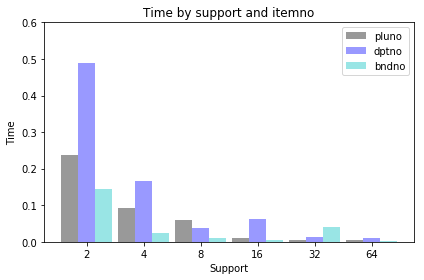

In [38]:
time_table(support, pluno_runtime2, dptno_runtime2, bndno_runtime2, 0.6)